# Filtrer les données d'OpenFoodFacts

Dans ce notebook, nous allons filtrer les données d'OpenFoodFacts selon différents critères, sur les lignes et les colonnes :
* La base de données OpenFoodFacts est ouverte à toutes les contributions, même incomplètes, et sans restriction géographique (produits vendus dans certains pays seulement). Un filtrage sur les lignes nous permettra de ne conserver que les produits vendus en France et dont la fiche est suffisamment remplie.
* Le modèle de données d'OpenFoodFacts est très complet et inclut de nombreux champs dont la valeur n'est directement renseignée que sur une minorité d'emballages, ou dont la valeur n'est pas directement calculable à partir des données contenues sur l'emballage. Un filtrage sur les colonnes nous permettra de ne conserver que les champs dont la valeur est remplie sur suffisamment de fiches.

Notez que pour d'autres cas d'usage, il peut être intéressant de ne pas appliquer de filtres aussi restrictifs pour travailler sur un plus grand nombre de fiches produits, éventuellement en inférant les valeurs manquantes.

Le site d'OpenFoodFacts fournit une documentation éparse, dont un fichier de description des champs du jeu de données : https://static.openfoodfacts.org/data/data-fields.txt

Nous pouvons charger les données d'OpenFoodFacts avec les optimisations du notebook précédent.

In [1]:
import pandas as pd
# pour les graphes
import seaborn as sns
sns.set()

In [2]:
# modifier le chemin vers le fichier CSV si nécessaire
CSV_FILE = '../data/en.openfoodfacts.org.products.csv'

In [3]:
# on charge les types de données qu'on a spécifiés dans le notebook 1
DTYPE_FILE = '../data/dtype.txt'
with open(DTYPE_FILE) as f:
    dtype = eval(f.read())
# pour rappel, on affiche les types de données explicites
dtype

{'origins': 'category',
 'origins_tags': 'category',
 'first_packaging_code_geo': 'category',
 'cities_tags': 'category',
 'purchase_places': 'category',
 'countries': 'category',
 'countries_tags': 'category',
 'countries_en': 'category',
 'traces_tags': 'category',
 'traces_en': 'category',
 'additives': 'category',
 'ingredients_from_palm_oil_tags': 'category',
 'ingredients_that_may_be_from_palm_oil_tags': 'category',
 'nutriscore_grade': 'category',
 'pnns_groups_1': 'category',
 'pnns_groups_2': 'category',
 'states': 'category',
 'states_tags': 'category',
 'states_en': 'category',
 'cities': 'float16',
 'allergens_en': 'float16',
 'serving_quantity': 'float16',
 'no_nutriments': 'float16',
 'additives_n': 'float16',
 'ingredients_from_palm_oil_n': 'float16',
 'ingredients_from_palm_oil': 'float16',
 'ingredients_that_may_be_from_palm_oil_n': 'float16',
 'ingredients_that_may_be_from_palm_oil': 'float16',
 'nutriscore_score': 'float16',
 'nova_group': 'float16',
 'energy-kj_100g

In [4]:
df_off = pd.read_csv(CSV_FILE, sep='\t', dtype=dtype)
df_off.info(memory_usage='deep')

/home/mathieu/miniconda3/envs/off-explore/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (0,24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1110884 entries, 0 to 1110883
Columns: 178 entries, code to carnitine_100g
dtypes: category(19), float16(120), int64(2), object(37)
memory usage: 2.7 GB


## Sélection de lignes : produits vendus en France

Quels sont le ou les champs contenant cette information?

Nous allons créer un masque sur les lignes du DataFrame :
`True` si le produit est vendu en France, `False` sinon.

La méthode '.str.contains()' permet de chercher une sous-chaîne dans une colonne de chaînes de caractères : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html

In [5]:
# utiliser .str.contains()
mask_fr = 
# remplacer les valeurs manquantes par False
mask_fr = 
mask_fr

0           True
1           True
2          False
3           True
4           True
           ...  
1110879     True
1110880    False
1110881     True
1110882    False
1110883    False
Name: countries_tags, Length: 1110884, dtype: bool

Nous pouvons maintenant connaître le nombre de produits vendus en France.

In [6]:
# utiliser value_counts() ou describe()


True     643862
False    467022
Name: countries_tags, dtype: int64

Nous allons nous concentrer sur ce sous-ensemble des données en ne conservant que les lignes correspondantes dans le DataFrame.

In [7]:
df_off_fr = df_off[mask_fr]
df_off_fr.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643862 entries, 0 to 1110881
Columns: 178 entries, code to carnitine_100g
dtypes: category(19), float16(120), int64(2), object(37)
memory usage: 1.7 GB


## Sélection de colonnes : champs (assez) souvent renseignés

Nous allons ignorer les colonnes qui ne sont jamais remplies, ou trop peu souvent pour qu'on puisse les utiliser raisonnablement pour l'analyse des données.

In [8]:
# afficher la liste des colonnes triées par le nombre de valeurs non-nulles qu'elles contiennent
# en utilisant 'count()'
col_counts = 
print(col_counts.to_string())

-melissic-acid_100g                                0
ingredients_from_palm_oil                          0
ingredients_that_may_be_from_palm_oil              0
-butyric-acid_100g                                 0
-caproic-acid_100g                                 0
cities                                             0
-caprylic-acid_100g                                0
-capric-acid_100g                                  0
-myristic-acid_100g                                0
-palmitic-acid_100g                                0
-stearic-acid_100g                                 0
-behenic-acid_100g                                 0
-lignoceric-acid_100g                              0
no_nutriments                                      0
allergens_en                                       0
-dihomo-gamma-linolenic-acid_100g                  0
-elaidic-acid_100g                                 0
-gondoic-acid_100g                                 0
-mead-acid_100g                               

Le nombre de valeurs non-nulles dans chaque colonne semble très variable.
Pour avoir une meilleure idée globale de la distribution correspondante, nous pouvons afficher un histogramme avec la bibliothèque seaborn (`sns.distplot`).

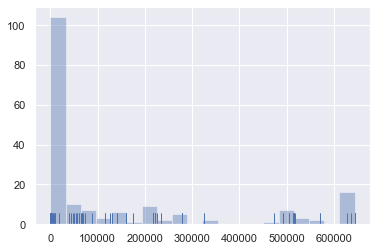

In [9]:
# afficher l'histogramme du nombre de valeurs non-nulles par colonne
sns.distplot(col_counts, bins=20, kde=False, rug=True)

Plusieurs colonnes sont totalement vides dans notre jeu de données actuel, nous pouvons les supprimer sans perte d'information.
La fonction `dropna` de pandas permet de supprimer les lignes ou les colonnes contenant une ou plusieurs valeurs manquantes : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html .

In [10]:
# utiliser dropna
df_sel = 
df_sel.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 643862 entries, 0 to 1110881
Columns: 156 entries, code to carnitine_100g
dtypes: category(19), float16(98), int64(2), object(37)
memory usage: 1.6 GB


Nous pouvons aller plus loin et enlever les colonnes très majoritairement vides, que nous aurons beaucoup de mal à exploiter dans l'exploration du jeu de données.
Empiriquement (et arbitrairement) nous décidons de ne conserver que les champs renseignés par plus de 1000 fiches (sur plus de 640000 fiches).

In [11]:
# utiliser dropna

df_sel.info(memory_usage='deep')

/home/mathieu/miniconda3/envs/off-explore/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 643862 entries, 0 to 1110881
Columns: 101 entries, code to nutrition-score-uk_100g
dtypes: category(18), float16(44), int64(2), object(37)
memory usage: 1.6 GB


## Sélection de lignes

De nombreuses fiches produits dans OpenFoodFacts ne sont remplies que très partiellement.
Un premier filtre assez simple consiste à ne conserver que les fiches où le nom et la marque du produit sont renseignés.

In [12]:
# utiliser 'dropna'

df_sel.info(memory_usage='deep')

/home/mathieu/miniconda3/envs/off-explore/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 322980 entries, 3 to 1110875
Columns: 101 entries, code to nutrition-score-uk_100g
dtypes: category(18), float16(44), int64(2), object(37)
memory usage: 961.2 MB


À chaque fiche produit d'OpenFoodFacts sont associées une ou plusieurs étiquettes d'états ('states') qui marquent le niveau de complétude et de qualité des données de la fiche.

Quels sont ces états? À quoi correspondent-ils?

Sur quelle(s) pages ou dans quel(s) fichier(s) avez-vous trouvé ces informations?

Nous filtrons maintenant les données pour conserver uniquement les fiches produits marquées "complètes".

In [13]:
# utiliser .str.contains
df_sel = 
df_sel.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90738 entries, 146 to 1110800
Columns: 101 entries, code to nutrition-score-uk_100g
dtypes: category(18), float16(44), int64(2), object(37)
memory usage: 343.3 MB


## Export du jeu de données filtré

Nous avons maintenant un jeu de données de dimensions plus modestes: 101 colonnes et environ 90000 lignes.

C'est ce jeu de données que nous allons explorer dans le prochain notebook.

In [14]:
# on fait un dump CSV du jeu de données filtré
SEL_FILE = '../data/off_subset.csv'
df_sel.to_csv(SEL_FILE, sep='\t', index=False)